In [1]:
# IMPORTANDO LIBRERIAS

import tensorflow_datasets as tfds
import math
import tensorflow as tf

2025-10-12 18:28:14.167076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 18:28:14.168908: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 18:28:14.195855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-12 18:28:14.195882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-12 18:28:14.196930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Cargando nuestro dataset
data, metadata = tfds.load('mnist', as_supervised=True, with_info=True)

In [3]:
# Funcion para normalizar nuestro dataset
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255 #Aqui lo pasa de 0-255 a 0-1
  return images, labels

In [4]:
# Dividimos nuestro dataset
train, test = data['train'], data['test']

In [5]:
# Guardamos los valores posibles de clasificacion
labels = metadata.features['label'].names

In [6]:
#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
train = train.map(normalize)
test = test.map(normalize)

In [7]:
# Cargamos a memoria para mas rapidez de entrenamiento
train = train.cache()
test = test.cache()

In [8]:
# Creamos el modelo
import keras
from keras import layers
model = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    # 🔹 Usa 'softmax' simple, no tf.nn.softmax ni softmax_v2
    layers.Dense(10, activation='softmax')
])

In [9]:
# Compilamos el modelo
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
train_size = metadata.splits["train"].num_examples
test_size = metadata.splits["test"].num_examples

#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
BATCH_SIZE = 32

In [11]:
#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
train = train.repeat().shuffle(train_size).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [12]:
%time history = model.fit(train, epochs=5, validation_data=test, steps_per_epoch= math.ceil(train_size/BATCH_SIZE), verbose=1 )

Epoch 1/5


1875/1875 [==============================] - 18s 8ms/step - loss: 0.2927 - accuracy: 0.9087 - val_loss: 0.0786 - val_accuracy: 0.9761
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1185 - accuracy: 0.9640 - val_loss: 0.0633 - val_accuracy: 0.9817
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0920 - accuracy: 0.9725 - val_loss: 0.0531 - val_accuracy: 0.9840
Epoch 4/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0751 - accuracy: 0.9780 - val_loss: 0.0531 - val_accuracy: 0.9851
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0667 - accuracy: 0.9793 - val_loss: 0.0463 - val_accuracy: 0.9869
CPU times: user 3min 25s, sys: 14.7 s, total: 3min 39s
Wall time: 1min 16s


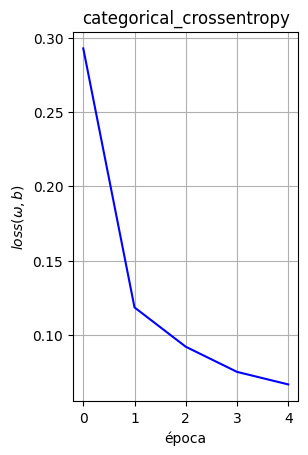

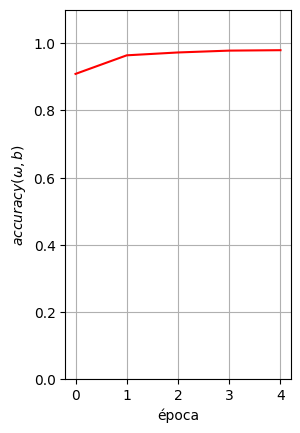

In [13]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'], 'b',label='error')
plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$loss(\omega, b)$')
plt.grid(True)
#plt.legend(loc='upper right')
plt.show()

plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'], 'r',label='precisión')
#plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$accuracy(\omega, b)$')
plt.ylim([0,1.1])
plt.grid(True)
#plt.legend(loc='lower right')
plt.show()

In [14]:
# Guardamos nuestro modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 128)         0

In [15]:
# Creando una carpeta de salida
import os

if not os.path.exists("output"):
  !mkdir "output"

In [16]:
import tensorflowjs as tfjs

model.export("numeros_CNN")

# Convertir a TensorFlow.js
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    numeros_CNN_savedmodel \
    ./output_tfjs


/home/lcc_rn_08/.conda/envs/ml_gpu/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


INFO:tensorflow:Assets written to: numeros_CNN/assets


INFO:tensorflow:Assets written to: numeros_CNN/assets


Saved artifact at 'numeros_CNN'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140537442864640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442709776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442708544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442712944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442862352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442869920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442874144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442865344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442868864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140537442873088: TensorSpec(shape=(), dtype=tf.resource, name=None)
2025-10-12 18:29:34.341745: